In [171]:
# Configure amd test GPU
import tensorflow as tf
from tensorflow.python.client import device_lib

# Prevent automatic GPU memory pre-allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
    tf.config.experimental.set_memory_growth(gpu, True)

print(tf.__version__)
# print(device_lib.list_local_devices())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.9.1


In [172]:
# Extract dataset
import os 

print(os.getcwd())
os.chdir('../datasets')
print(os.getcwd())

/home/jovyan/committed_git/datasets
/home/jovyan/committed_git/datasets


In [173]:
from sklearn.model_selection import train_test_split
import numpy as np

# Import dataset
features = np.load('augmented_features_10_ue1_v2_ds.npy')
labels = np.load('augmented_labels_10_ue1_v2_ds.npy')

print(f'Shape of features np array: {features.shape}')
print(f'Shape of labels np array: {labels.shape}')

X = features
y = labels

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Shape of features np array: (89628, 193, 16)
Shape of labels np array: (89628,)


## Offline Phase:

1. Step 1: Selection of RPs.
2. Reduce dimensions of fingerprint (Paper uses Ftt method but our method takes the average of repeated measurements at each frequency channel).
3. Perform clustering of RPs using fingerprints with reduced dimensions.
4. Create a database containing {Coords(x,y), Cluster no., Fingerprint with reduced dimensions).
5. Apply LSH algorithm to hash fingerprints generated by cluster.

### Step 1: Reduce dimensions of array using Three Tuple Algorithm (Ftt)

- Can try using convolution layer
- Can try use three tuple algorithm method (May be useful only for sparse matrices)

### Step 2: Perform clustering using K-Means (K-Means Cluster)

- Method 1: PCA / t-SNE
- Method 2: Take averages
- Method 4: Flatten the array

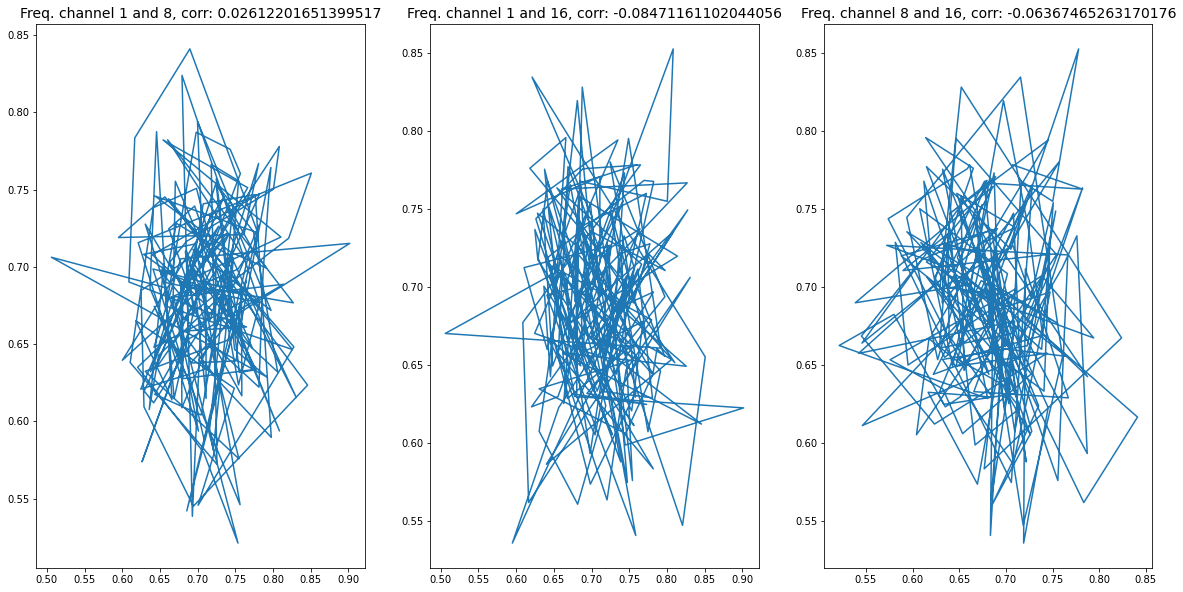

In [16]:
import matplotlib.pyplot as plt

# First, see if the data is linear or not
# Retrieve values from two frequency channels from the same sample over 
# multiple samples and do a scatterplot
# Find out correlation as well

# Retrieve the first feature
sample_feature = X_train[0]

# Retrieve measurements from the freq channel 1, 8 and 16
freqchannel1 = sample_feature[:,0]
freqchannel2 = sample_feature[:,7]
freqchannel3 = sample_feature[:,15]

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(1,3)

axs[0].set_title(f'Freq. channel 1 and 8, corr: {np.corrcoef(freqchannel1, freqchannel2)[0,1]}', fontsize = 14)
axs[0].plot(freqchannel1, freqchannel2)

axs[1].set_title(f'Freq. channel 1 and 16, corr: {np.corrcoef(freqchannel1, freqchannel3)[0,1]}', fontsize = 14)
axs[1].plot(freqchannel1, freqchannel3)

axs[2].set_title(f'Freq. channel 8 and 16, corr: {np.corrcoef(freqchannel2, freqchannel3)[0,1]}', fontsize = 14)
axs[2].plot(freqchannel2, freqchannel3)

In [184]:
# As data across different samples are taken at different time intervals, makes
# sense to average the value out
# Reduce each feature from shape of (193, 16) --> (1, 16)

# Preprocess X_train and X_test => Reduce dimensions by averaging
reduced_X_train = []
reduced_X_test = []

for feature in X_train:  
    reduced_X_train.append(np.mean(feature, axis = 0))
for feature in X_test:
    reduced_X_test.append(np.mean(feature, axis = 0))
    
X_train = np.array(reduced_X_train)
X_test = np.array(reduced_X_test)

print(X_train.shape)
print(X_test.shape)

(71702, 16)
(17926, 16)


In [185]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [179]:
inertias, distortions = [], []
inertias_mapping, distortions_mapping = {}, {}
K = range(1, 20)

for k in K:
    
    # Build and fit the model
    kmeanModel = KMeans(n_clusters = k).fit(X_train)
    kmeanModel.fit(X_train)
    
    distortions.append(sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_train.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    inertias_mapping[k] = sum(np.min(cdist(X_train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X_train.shape[0]
    distortions_mapping[k] = kmeanModel.inertia_

#### Metrics used:

- Distortion: Average of the squared distances from the cluster centers of the respective clusters to each data point (Euclidean distance metric)

- Inertia: Average sum of squared distances of samples to their closest cluster centre

In [180]:
for key,val in inertias_mapping.items():
    print(f'No. of clusters: {key}, inertias: {val}')

No. of clusters: 1, inertias: 0.5363316960429995
No. of clusters: 2, inertias: 0.4750941792684408
No. of clusters: 3, inertias: 0.431973008199725
No. of clusters: 4, inertias: 0.3997290023811501
No. of clusters: 5, inertias: 0.36183796465559603
No. of clusters: 6, inertias: 0.3323592064411866
No. of clusters: 7, inertias: 0.319621414276987
No. of clusters: 8, inertias: 0.3074309831664756
No. of clusters: 9, inertias: 0.29658059947807663
No. of clusters: 10, inertias: 0.2888429038733291
No. of clusters: 11, inertias: 0.28129038602301154
No. of clusters: 12, inertias: 0.2748599303863045
No. of clusters: 13, inertias: 0.2689964138889303
No. of clusters: 14, inertias: 0.2647799845824608
No. of clusters: 15, inertias: 0.2598982673424333
No. of clusters: 16, inertias: 0.25653214643578404
No. of clusters: 17, inertias: 0.2519857851262393
No. of clusters: 18, inertias: 0.24874113142911874
No. of clusters: 19, inertias: 0.24562293141799563


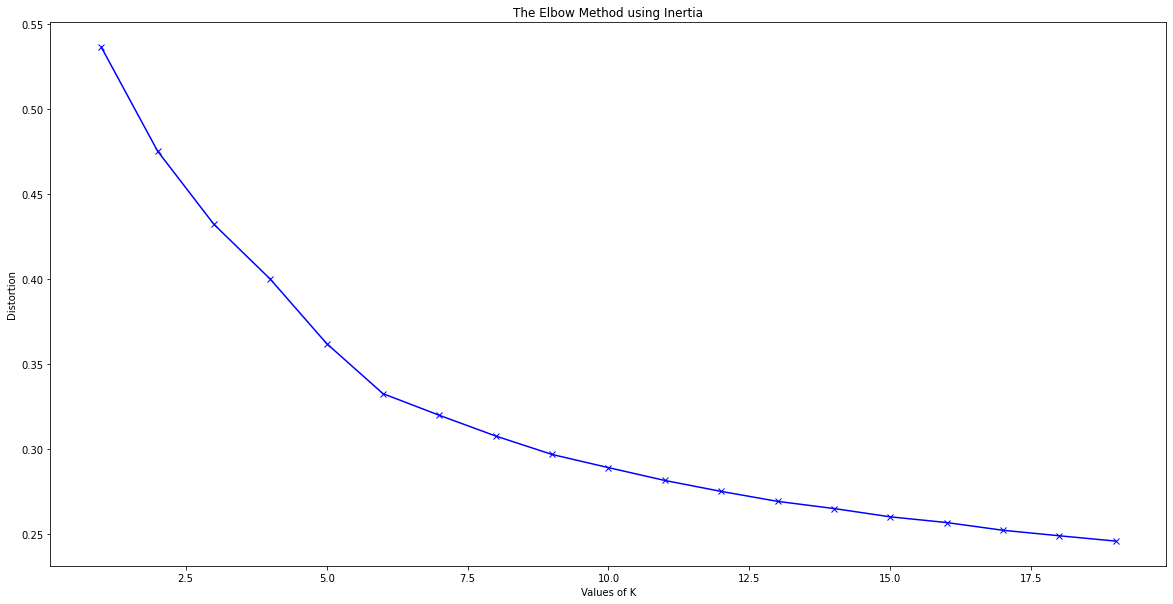

In [181]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Inertia')
plt.show()

In [182]:
for key,val in distortions_mapping.items():
    print(f'No. of clusters: {key}, distortion: {val}')

No. of clusters: 1, distortion: 21841.907168491467
No. of clusters: 2, distortion: 17415.012126380363
No. of clusters: 3, distortion: 14425.495470297068
No. of clusters: 4, distortion: 12189.391213838757
No. of clusters: 5, distortion: 10137.244002683117
No. of clusters: 6, distortion: 8621.437757923864
No. of clusters: 7, distortion: 7960.194419675813
No. of clusters: 8, distortion: 7353.421935603191
No. of clusters: 9, distortion: 6801.638848209186
No. of clusters: 10, distortion: 6446.499240625197
No. of clusters: 11, distortion: 6101.452523155159
No. of clusters: 12, distortion: 5824.011766266433
No. of clusters: 13, distortion: 5603.30090779632
No. of clusters: 14, distortion: 5396.198959389618
No. of clusters: 15, distortion: 5225.016058255846
No. of clusters: 16, distortion: 5075.420523312527
No. of clusters: 17, distortion: 4914.13716677106
No. of clusters: 18, distortion: 4794.883652791822
No. of clusters: 19, distortion: 4670.469500248675


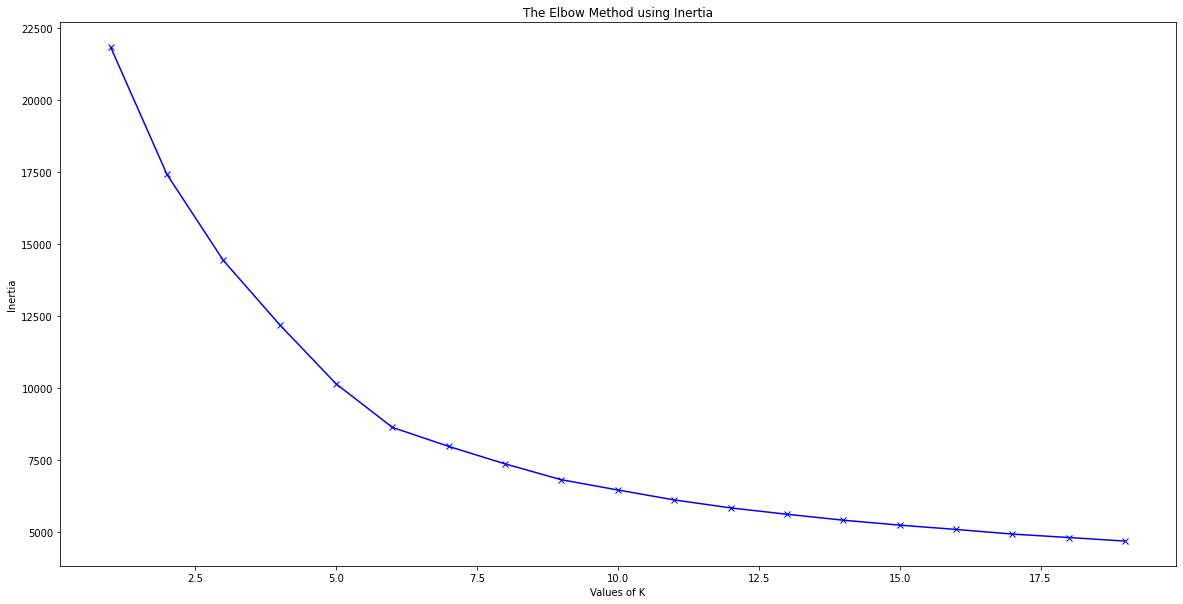

In [183]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

Optimal no. of clusters = 6

### Step 3: Generate fingerprint database with structure {Loci(xi, yi), K-Means Cluster, Ftt}
- Use original fingerprint if do not plan to reduce the dimensions of each fingerprint

In [190]:
# print(os.getcwd())

/home/jovyan/committed_git/datasets


In [191]:
import h5py

# Get dictionary of RP index and coordinates
# Open HDF5 file and access the dataset
filename = 'dataset_SNR10_outdoor.mat'
hdf5_file = h5py.File(filename, 'r')

features_dataset = hdf5_file['features']
labels_dataset = hdf5_file['labels']['position']

# Convert HDF5 dataset to NumPy array
features = np.array(features_dataset)
labels = np.array(labels_dataset)

# Prepare features for dataset
# Retrieve features from the first UE and transpose the individual matrix
features_transposed = np.zeros((3876,193,16), dtype = np.float64)
for i in range(len(features)):
    features_transposed[i] = features[i][0].T

# Prepare labels for dataset
count = 0
rp_dict = {}
# For labels, have a shape of (1,) where that number represents the class of that coordinate

for label in labels:
    rp_dict[count] = label
    count += 1

# Close the HDF5 file
hdf5_file.close()

In [194]:
# print(len(labels))
# print(rp_dict)

3876
{0: array([17. , 43.5, 21.7]), 1: array([17. , 44. , 21.7]), 2: array([17. , 44.5, 21.7]), 3: array([17. , 45. , 21.7]), 4: array([17. , 45.5, 21.7]), 5: array([17. , 46. , 21.7]), 6: array([17. , 46.5, 21.7]), 7: array([17. , 47. , 21.7]), 8: array([17. , 47.5, 21.7]), 9: array([17. , 48. , 21.7]), 10: array([17. , 48.5, 21.7]), 11: array([17. , 49. , 21.7]), 12: array([17. , 49.5, 21.7]), 13: array([17. , 50. , 21.7]), 14: array([17. , 50.5, 21.7]), 15: array([17. , 51. , 21.7]), 16: array([17. , 51.5, 21.7]), 17: array([17. , 52. , 21.7]), 18: array([17. , 52.5, 21.7]), 19: array([17. , 53. , 21.7]), 20: array([17. , 53.5, 21.7]), 21: array([17. , 54. , 21.7]), 22: array([17. , 54.5, 21.7]), 23: array([17. , 55. , 21.7]), 24: array([17. , 55.5, 21.7]), 25: array([17. , 56. , 21.7]), 26: array([17. , 56.5, 21.7]), 27: array([17. , 57. , 21.7]), 28: array([17. , 57.5, 21.7]), 29: array([17. , 58. , 21.7]), 30: array([17. , 58.5, 21.7]), 31: array([17. , 59. , 21.7]), 32: array([1

In [233]:
# Perform clustering using optimal number of clusters
kmeans_model = KMeans(n_clusters = 6).fit(X_train)

# Get the correct cluster for each of the RP
label_arr = kmeans_model.labels_
print(f'No. of unique clusters: {np.unique(label_arr)}')
print(f'No. of fp clustered: {len(label_arr)}')

# Create a database containing key-value of location vector, cluster no. and fingerprint
processed_fp_db = []
for i in range(len(X_train)):
    
    processed_fp = {}
    processed_fp['coords_idx'] = y_train[i]
    processed_fp['cluster_no'] = label_arr[i]
    processed_fp['fp'] = reduced_dims_features[i]
    processed_fp_db.append(processed_fp)

print(len(processed_fp_db), processed_fp_db[0])

No. of unique clusters: [0 1 2 3 4 5]
No. of fp clustered: 71702
71702 {'coords_idx': 383, 'cluster_no': 3, 'fp': array([0.64390807, 0.26444111, 0.56497193, 0.58222285, 0.66000711,
       0.29986503, 0.52431564, 0.61377072, 0.66395987, 0.35654856,
       0.47202562, 0.64252936, 0.65919535, 0.41383729, 0.42154467,
       0.65629   ])}


### Step 4: Apply LSH algorithm for each of the clusters to hash fingerprints generated  and save the hash values in a data structure.

- Components of LSH algorithm
    - Stable distribution: Gaussian normal distribution with mean = 0 and variance = 1
    - dimension, d: Dimensions of the fingerprints with reduced dimensions, with shape of (1,16)
    - alpha, a: Vector of dimension d whose entry are chosen independently from the p-stable distribution.
    - vector v: Vector of dimension d that represents our fingerprint
    - r: Length of segment, by 'chopping' real line into eqi-distance segment of length r
    - b: A random number in the range of (0,r)

### Data Visualisation

In [196]:
alpha_vector = np.random.standard_normal(size = (1,16))

Cluster 0
Max: 2.0834981115725033, Min: 0.7666042843787988, Avg: 1.3716000868266263, IQR: 0.3305636766128286, No. of bins: 39
Cluster 1
Max: 3.2166920242234878, Min: 2.2951363515139094, Avg: 2.8234814375977, IQR: 0.27686400511989806, No. of bins: 33
Cluster 2
Max: 3.19647783284279, Min: 0.7586252492518701, Avg: 1.7608397336962824, IQR: 0.43290580423090863, No. of bins: 71
Cluster 3
Max: 3.5082753560005075, Min: 1.1446080589387932, Avg: 2.3847333768635615, IQR: 0.6338145249221263, No. of bins: 46
Cluster 4
Max: 2.84849446633935, Min: 1.1037287727546858, Avg: 2.001268945971302, IQR: 0.5662873737069838, No. of bins: 33
Cluster 5
Max: 3.5393466445341826, Min: 1.2182050042382062, Avg: 2.5954336146520736, IQR: 0.39570491047329304, No. of bins: 76


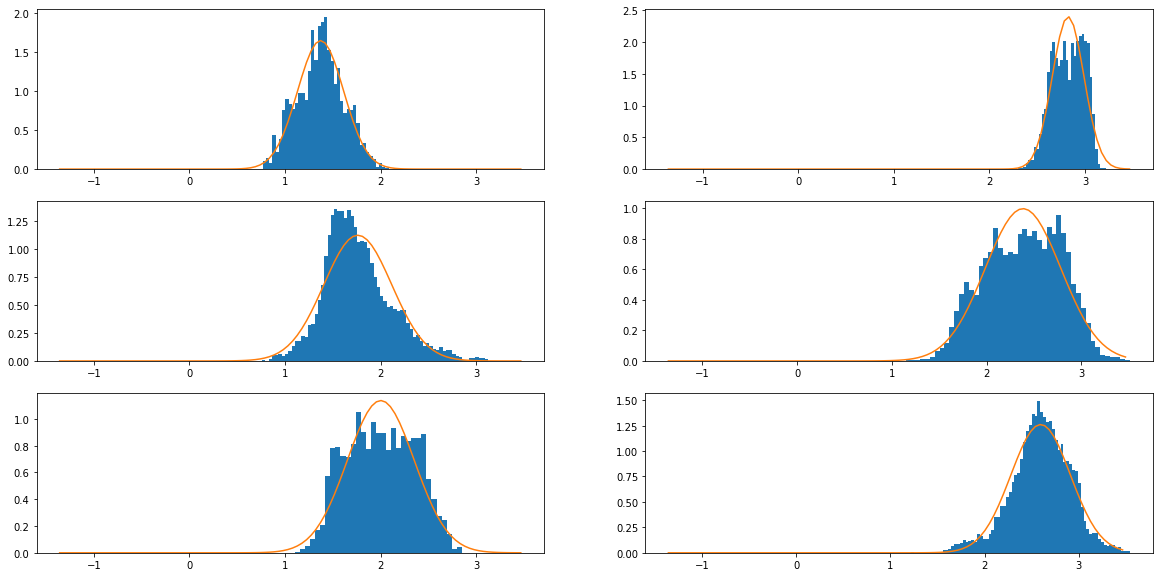

In [234]:
# Get stable distribution - Gaussian normal distribution with mean = 0 and variance = 1,
# with dimension d => (1,16)
import random
from scipy.stats import norm

# Perform dot product alpha_vector . vector v = scalar
# scalar = np.dot(alpha_vector, reduced_dims_features[0])

# For each cluster,
cluster0_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 0]
cluster1_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 1]
cluster2_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 2]
cluster3_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 3]
cluster4_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 4]
cluster5_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == 5]

plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2)

for i in range(3):
    for j in range(i,i + 2):

        # Determine the elements from each cluster 
        print(f'Cluster {i + j}')
        cluster_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == (i + j)]
        
        # Get distribution of scalar quantities for each poimt
        num_features = len(cluster_rps)
        scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
        for k in range(num_features):
            scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
        
        (n, bins, patches) = axs[i][j - i].hist(scalar_res, bins = 'auto', density = True)
#       print(f'Number of bins: {len(n)}, Data point count for each bin: {n}')

        max_val = np.amax(scalar_res)
        min_val = np.amin(scalar_res)
        avg_val = np.mean(scalar_res)
        q75, q25 = np.percentile(scalar_res, [75,25])
        iqr = q75 - q25
    
        print(f'Max: {max_val}, Min: {min_val}, Avg: {avg_val}, IQR: {iqr}, No. of bins: {len(n)}')
        axs[i][j - i].plot(x, norm.pdf(x, np.mean(scalar_res), np.std(scalar_res)))

In [236]:
# Generation of hash function
# Let length r be (cluster max - cluster min) / 100
# Stick to 100 hash values for now to make sure data points are evenly spread out, but not too little
# points per hash value
import math

def get_minmax(cluster_rps):
    
    num_features = len(cluster_rps)
    scalar_res = np.zeros(shape = (num_features, 1), dtype = np.float64)
    
    for k in range(num_features):
        scalar_res[k] = np.dot(alpha_vector, cluster_rps[k]['fp'])
    
    return (np.amax(scalar_res), np.amin(scalar_res))

def get_hash_values(cluster_rps):
    
    max_val, min_val = get_minmax(cluster_rps)
    
    # Declare parameters of hash function
    num_segments = 100
    r = (max_val - min_val) / num_segments
    b = random.uniform(0, r)
    
    # print(r,b)
    
    # Make hash table
    hash_table = {}
    
    # Generate hash values for each of the RP
    for rp in cluster_rps:
        
        hash_value = math.floor((np.dot(alpha_vector, rp['fp']) + b) / r)
        cur_vals = hash_table.get(hash_value, [])
        cur_vals.append(rp['coords_idx'])
        hash_table[hash_value] = cur_vals
        
    return r, b, hash_table

Cluster 0
r: 0.013168938271937046, b: 0.006624823545088765
Cluster 1
r: 0.009215556727095784, b: 0.005819427490099436
Cluster 2
r: 0.0243785258359092, b: 0.018032228053537856
Cluster 3
r: 0.023636672970617143, b: 0.007615085946470478
Cluster 4
r: 0.017447656935846642, b: 0.008689765871991864
Cluster 5
r: 0.02321141640295976, b: 0.00323486347448501


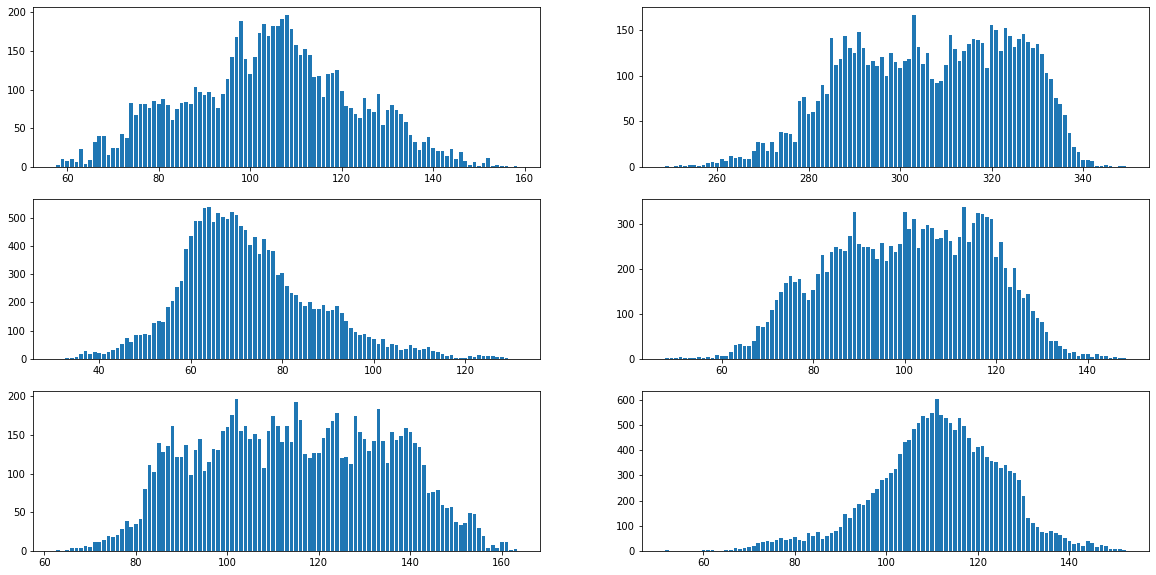

In [237]:
# For each cluster, visualise the spread of hashed values using a histogram
plt.rcParams['figure.figsize'] = [20, 10]
fig, axs = plt.subplots(3,2)

for i in range(3):
    for j in range(i,i + 2):

        # Determine the elements from each cluster 
        print(f'Cluster {i + j}')
        cluster_rps = [rp for rp in processed_fp_db if rp['cluster_no'] == (i + j)]
        
        # Get hash values for each cluster
        r, b, hash_vals = get_hash_values(cluster_rps)
        print(f'r: {r}, b: {b}')
        
        keys = []
        num_vals = []
        
        for key, values in hash_vals.items():
            keys.append(key)
            num_vals.append(len(values))
            
        axs[i][j - i].bar(x = keys, height = num_vals)

In [204]:
# Get hash values for each cluster 
r0, b0, cluster0_hashvals = get_hash_values(cluster0_rps)
r1, b1, cluster1_hashvals = get_hash_values(cluster1_rps)
r2, b2, cluster2_hashvals = get_hash_values(cluster2_rps)
r3, b3, cluster3_hashvals = get_hash_values(cluster3_rps)
r4, b4, cluster4_hashvals = get_hash_values(cluster4_rps)
r5, b5, cluster5_hashvals = get_hash_values(cluster5_rps)

In [238]:
# Save details of each hash function into a dictionary
clustered_rps = [cluster0_rps, cluster1_rps, cluster2_rps, cluster3_rps, cluster4_rps, cluster5_rps]
clustered_rps = enumerate(clustered_rps)
hash_dict = {}

for index, cluster in clustered_rps:
    r, b, hash_vals = get_hash_values(cluster)
    hash_dict[index] = {'r': r, 'b': b, 'hashs': hash_vals}

In [239]:
hash_dict

{0: {'r': 0.013168938271937046,
  'b': 0.0033261512828599003,
  'hashs': {108: [1956,
    2434,
    2202,
    561,
    361,
    1956,
    2546,
    2222,
    472,
    2161,
    246,
    2399,
    2430,
    72,
    2161,
    2385,
    304,
    2128,
    448,
    2404,
    2385,
    226,
    127,
    2085,
    226,
    2222,
    303,
    445,
    570,
    287,
    2455,
    293,
    1956,
    304,
    335,
    271,
    226,
    277,
    161,
    2267,
    2138,
    361,
    2051,
    72,
    127,
    2535,
    2268,
    1956,
    2039,
    1956,
    395,
    386,
    438,
    2235,
    557,
    522,
    382,
    304,
    2385,
    183,
    464,
    386,
    2458,
    445,
    382,
    293,
    361,
    494,
    287,
    557,
    2458,
    2141,
    2085,
    703,
    2222,
    2142,
    2051,
    2222,
    417,
    472,
    367,
    570,
    334,
    2201,
    386,
    445,
    2546,
    477,
    382,
    386,
    100,
    293,
    361,
    1987,
    2357,
    193,
    382,
    2161,
   

## Online Phase:

1. Take fingerprint at unknown location.
2. Determine appropriate cluster for that fingerprint.
3. Apply LSH algorithm to selected clustering and get top candidate RP for localisation (Apply hash function to unknown fingerprint and get top candidate RPs with the same hash values).
4. Use Euclidean Distance criterion to calculate distance between each pair of points.
5. Exploit WKNN algorithm to choose first K RPs with the smallest Dis to estimate final positioning.

In [253]:
# Function to calculate Euclidean distance
def get_ed(actual_rp, candidate_rp):
    return math.dist(actual_rp, candidate_rp)

# Let's try on one test point for now
# Use clustering to predict cluster of unknown fingerprint
X_test_sample = X_test[0]
y_test_sample = y_test[0]

predicted_cluster = kmeans_model.predict([X_test_sample])[0]

# Apply LSH hash function to get cluster for unknown fingerprint
r, b, hash_vals = hash_dict[predicted_cluster]['r'], hash_dict[predicted_cluster]['b'], hash_dict[predicted_cluster]['hashs']

# print(X_test_sample.shape)
hashed_value = math.floor((np.dot(alpha_vector, X_test_sample) + b) / r)
# print(hashed_value)
# print(hash_vals[hashed_value])

# Exploit WKNN algorithm to choose first K RPs
# Here, let k = 3, weight = 1 / get_ed(actual_rp, candidate_rp)
# candidate_rps should be given in as a key which is the key in rp_dict which maps back to the
# actual coordinates 
def wknn(actual_rp, candidate_rps, k = 3):
    
    distances = []
    
    # For every candidate point,
    for index in candidate_rps:
        
        # Calculate the distance from each candidate point
        coords = rp_dict[index]
        dist = get_ed(rp_dict[actual_rp], coords)
        
        if dist == 0:
            weight = 100
        else:
            weight = 1 / dist
            
        distances.append((index, coords, weight, dist))
        
    # Sort the array based on dist
    sorted_distances = sorted(distances, key = lambda tup: tup[3])
            
    # Exploit WKNN to get positioning
    # Get top candidates
    top_k_candidates = sorted_distances[:k]
    
    # For checking purposes
    # for index, _ , _ in top_k_candidates:
    #    print(rp_dict[index])
    
    # Get predicted positioning using best candidates
    # Get coordinates for all candidate positions
    candidate_pos = []
    weights = []
    
    for _, candidate, weight, _ in top_k_candidates:
        candidate_pos.append(candidate)
        weights.append(weight)
    
    predicted_position = np.average(candidate_pos, weights = weights, axis = 0)
    return predicted_position
    
print('Predicted:')
print(wknn(y_test_sample, hash_vals[hashed_value]))
print('--')
print('Actual')
print(rp_dict[y_test_sample])

Predicted:
[23.  46.  22.2]
--
Actual
[23.  46.  22.2]
